## Group Members: Muhammad Salman & Shahid Ullah
## Roll No.: 22I-2027 & 22I-2019
# --------------------------------------------------------

# For phishing_site_urls.csv Dataset 

# 1. Libaries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tldextract
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

# 2. Data Preprocessing and Feature Selection & Extraction

In [ ]:
# Load Dataset
df = pd.read_csv("phishing_site_urls.csv")

# Map labels: bad -> 1, good -> 0
df['Label'] = df['Label'].map({'bad': 1, 'good': 0})

# Remove nulls & duplicates
df = df.dropna().drop_duplicates().reset_index(drop=True)
print("After Null & Duplicate Removal:", df.shape)

#Manual Feature Extraction + Undersampling
def extract_features(url):
    features = {}
    features['url_len'] = len(url)
    features['dot_count'] = url.count('.')
    features['digit_count'] = sum(c.isdigit() for c in url)
    features['special_count'] = len(re.findall(r'[@_!#$%^&*()<>?/\|}{~:]', url))
    features['hyphen_count'] = url.count('-')
    features['double_slash'] = url.count('//')
    features['single_slash'] = url.count('/')
    features['at_count'] = url.count('@')
    features['protocol_https'] = 1 if url.startswith("https") else 0
    return features

# Extract features
feature_list = df['URL'].apply(extract_features)
X_manual = pd.DataFrame(feature_list.tolist())
y_manual = df['Label']

# Combine
df_manual = pd.concat([X_manual, y_manual], axis=1)

print("\nManual Features - Class distribution before balancing:\n", df_manual['Label'].value_counts())

# Undersampling
count_class_0, count_class_1 = df_manual['Label'].value_counts()
if count_class_0 > count_class_1:
    df_class_0 = df_manual[df_manual['Label'] == 0]
    df_class_1 = df_manual[df_manual['Label'] == 1]
    df_class_0_under = resample(df_class_0, replace=False, n_samples=count_class_1, random_state=42)
    df_balanced = pd.concat([df_class_0_under, df_class_1])
else:
    df_class_0 = df_manual[df_manual['Label'] == 0]
    df_class_1 = df_manual[df_manual['Label'] == 1]
    df_class_1_under = resample(df_class_1, replace=False, n_samples=count_class_0, random_state=42)
    df_balanced = pd.concat([df_class_1_under, df_class_0])

# Shuffle
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("Manual Features - After Balancing:", df_balanced.shape)
print("Manual Features - Final Label Distribution:\n", df_balanced['Label'].value_counts())

X_final_manual = df_balanced.drop(columns=["Label"])
y_final_manual = df_balanced["Label"]

print("Manual Features - Final Feature Shape:", X_final_manual.shape)


After Null & Duplicate Removal: (507196, 2)

Manual Features - Class distribution before balancing:
 Label
0    392897
1    114299
Name: count, dtype: int64
Manual Features - After Balancing: (228598, 10)
Manual Features - Final Label Distribution:
 Label
0    114299
1    114299
Name: count, dtype: int64
Manual Features - Final Feature Shape: (228598, 9)


# 3. Train-Test Split

In [ ]:
# Ensure numeric for manual features
X_final_manual = X_final_manual.apply(pd.to_numeric, errors='coerce')
X_final_manual = X_final_manual.fillna(X_final_manual.median())

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_final_manual, y_final_manual, test_size=0.2, random_state=42, stratify=y_final_manual
)

# Scale 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train Shape:", X_train.shape, "Test Shape:", X_test.shape)


Train Shape: (182878, 9) Test Shape: (45720, 9)


# 4. Train Models and Evaluation

In [ ]:
#Train Models and Evaluation
models = {
    "Decision Tree": DecisionTreeClassifier(criterion="entropy", random_state=0),
    "Random Forest": RandomForestClassifier(n_estimators=20, criterion="entropy", random_state=0),
    "SVM": SVC(kernel="rbf", C=10, gamma=1, probability=True, random_state=0),
    "Random Baseline": DummyClassifier(strategy="uniform", random_state=0)
}

results = {}

for name, model in models.items():
    start = time.time()
    model.fit(X_train_scaled, y_train)
    train_time = time.time() - start
    
    y_pred = model.predict(X_test_scaled)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "Train Time (s)": train_time
    }
    
    print(f"\n{name} Results:")
    print("Accuracy:", round(acc, 4))
    print("Precision:", round(prec, 4))
    print("Recall:", round(rec, 4))
    print("F1 Score:", round(f1, 4))
    print("Training Time (s):", round(train_time, 4))

results_df = pd.DataFrame(results).T
print("\nFinal Results Table:\n")
results_df


Decision Tree Results:
Accuracy: 0.7932
Precision: 0.811
Recall: 0.7647
F1 Score: 0.7872
Training Time (s): 0.6276

Random Forest Results:
Accuracy: 0.8026
Precision: 0.8172
Recall: 0.7797
F1 Score: 0.798
Training Time (s): 4.7457

SVM Results:
Accuracy: 0.7936
Precision: 0.8066
Recall: 0.7723
F1 Score: 0.7891
Training Time (s): 28091.0212

Random Baseline Results:
Accuracy: 0.4961
Precision: 0.4961
Recall: 0.4966
F1 Score: 0.4964
Training Time (s): 0.0207

Final Results Table:



,Accuracy,Precision,Recall,F1,Train Time (s)
Decision Tree,0.793241,0.811024,0.764654,0.787157,0.627570
Random Forest,0.802647,0.817231,0.779659,0.798003,4.745746
SVM,0.793570,0.806634,0.772266,0.789076,28091.021245
Random Baseline,0.496085,0.496089,0.496632,0.496360,0.020694


# 5. Graphs and Confusion Matrices

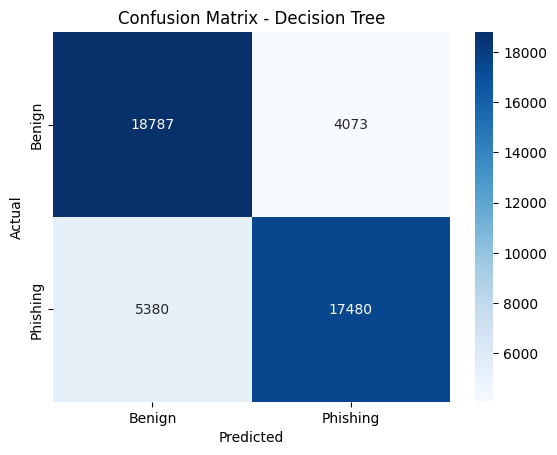

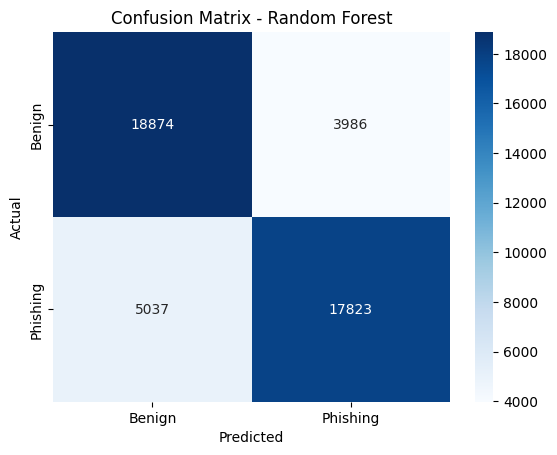

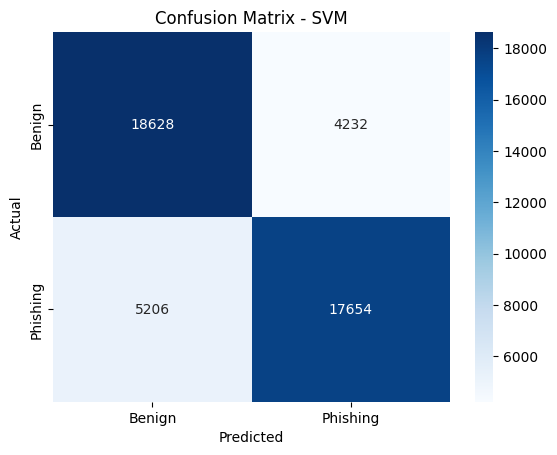

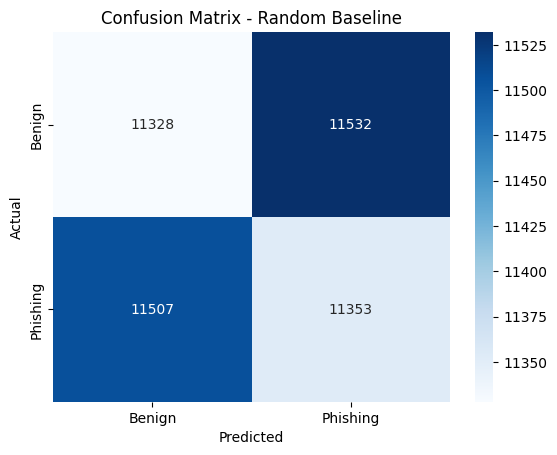

In [5]:
# Confusion Matrices
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign","Phishing"], yticklabels=["Benign","Phishing"])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

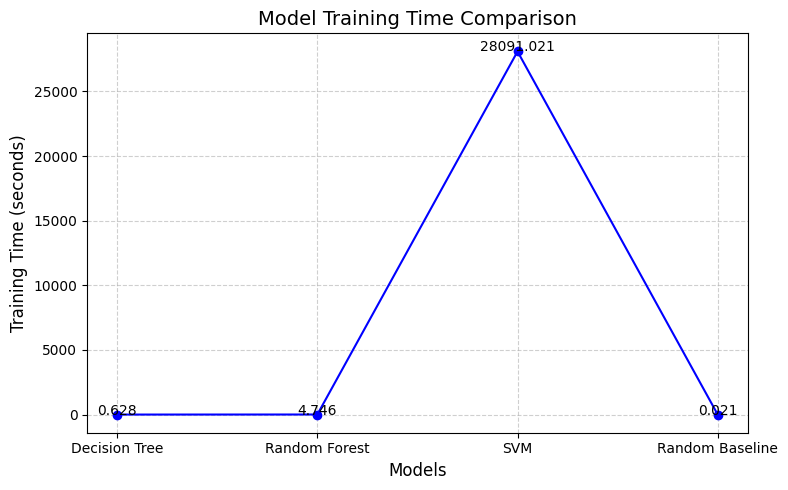

In [6]:
import matplotlib.pyplot as plt

# Extract training times
train_times = results_df["Train Time (s)"]

plt.figure(figsize=(8,5))
plt.plot(train_times.index, train_times.values, marker='o', linestyle='-', color='b')

plt.title("Model Training Time Comparison", fontsize=14)
plt.xlabel("Models", fontsize=12)
plt.ylabel("Training Time (seconds)", fontsize=12)

for i, v in enumerate(train_times.values):
    plt.text(i, v + 0.001, f"{v:.3f}", ha='center', fontsize=10)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


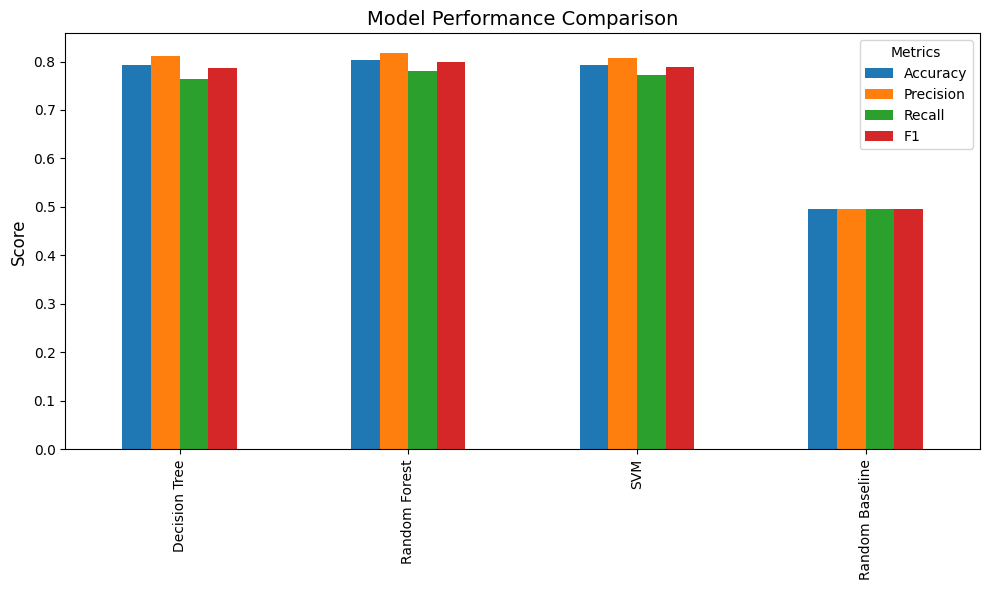

In [9]:
# Bar chart for Accuracy, Precision, Recall, F1
results_df[['Accuracy','Precision','Recall','F1']].plot(kind="bar", figsize=(10,6))

plt.title("Model Performance Comparison", fontsize=14)
plt.ylabel("Score", fontsize=12)
plt.legend(title="Metrics")
plt.tight_layout()
plt.show()


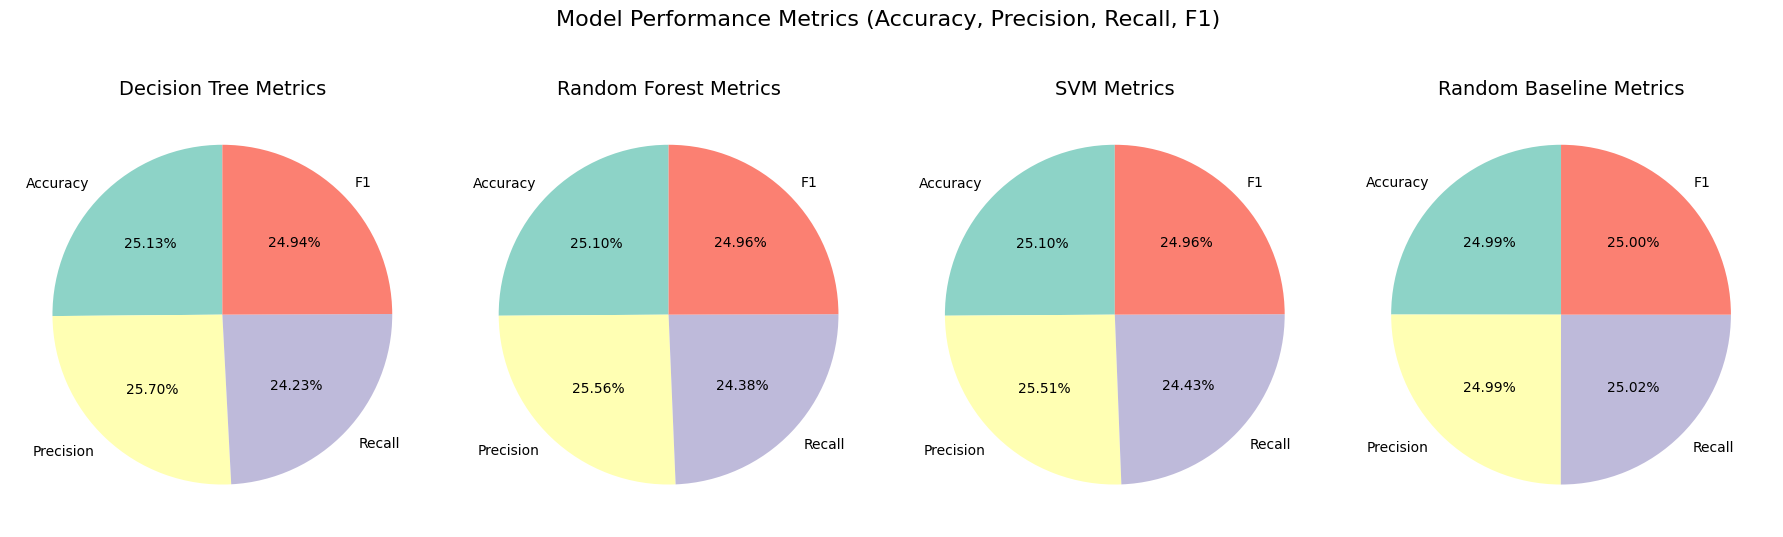

In [10]:
models = results_df.index
metrics_list = ["Accuracy", "Precision", "Recall", "F1"]

# Setup subplots
fig, axes = plt.subplots(1, len(models), figsize=(18,6))

for i, model_name in enumerate(models):
    metrics = results_df.loc[model_name, metrics_list]
    
    axes[i].pie(metrics.values, 
                labels=metrics.index, 
                autopct="%1.2f%%", 
                startangle=90, 
                colors=plt.cm.Set3.colors)
    
    axes[i].set_title(f"{model_name} Metrics", fontsize=14)

plt.suptitle("Model Performance Metrics (Accuracy, Precision, Recall, F1)", fontsize=16)
plt.tight_layout()
plt.show()


In [11]:
import plotly.express as px

for model_name in results_df.index:
    metrics = results_df.loc[model_name, ["Accuracy","Precision","Recall","F1"]]
    pie_data = metrics.reset_index()
    pie_data.columns = ["Metric", "Score"]

    fig = px.pie(pie_data, names="Metric", values="Score",
                 title=f"{model_name} Performance Metrics", hole=0.3)
    fig.update_traces(textposition='inside', textinfo='percent+label')

    # Force open in browser instead of Jupyter
    import plotly.io as pio
    pio.renderers.default = "browser"
    fig.show()
